In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORTING NECESSARY LIBRARIES

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    warnings.filterwarnings("ignore", category=DeprecationWarning) 

# LOADING DATASETS

In [3]:
# Paths for data.
Ravdess = "/content/drive/MyDrive/Minor project /Datesets/Audio_Song_Actors_01-24.zip (Unzipped Files)/"
Savee = "/content/drive/MyDrive/Minor project /Datesets/AudioData/"

In [4]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df

Emotions                                               Path
0     neutral  /content/drive/MyDrive/Minor project /Datesets...
1     neutral  /content/drive/MyDrive/Minor project /Datesets...
2     neutral  /content/drive/MyDrive/Minor project /Datesets...
3     neutral  /content/drive/MyDrive/Minor project /Datesets...
4        calm  /content/drive/MyDrive/Minor project /Datesets...
...       ...                                                ...
1007     fear  /content/drive/MyDrive/Minor project /Datesets...
1008     fear  /content/drive/MyDrive/Minor project /Datesets...
1009     fear  /content/drive/MyDrive/Minor project /Datesets...
1010     fear  /content/drive/MyDrive/Minor project /Datesets...
1011     fear  /content/drive/MyDrive/Minor project /Datesets...

[1012 rows x 2 columns]

In [5]:
savee_directory_list = os.listdir(Savee)
savee_directory_list=savee_directory_list[:-2]
print(savee_directory_list)
file_emotion = []
file_path = []
for dir in savee_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    folder_list = os.listdir(Savee +"/"+dir+"/")

    for file in folder_list:
        file_path.append(Savee +dir+"/"+file)
        part = file.split('.')[0]
        ele = part[:-2]
        # print(ele[0:10])
        if ele=='a':
            file_emotion.append('angry')
        elif ele=='d':
            file_emotion.append('disgust')
        elif ele=='f':
            file_emotion.append('fear')
        elif ele=='h':
            file_emotion.append('happy')
        elif ele=='n':
            file_emotion.append('neutral')
        elif ele=='sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df


['DC', 'JE', 'JK']


Emotions                                               Path
0       angry  /content/drive/MyDrive/Minor project /Datesets...
1       angry  /content/drive/MyDrive/Minor project /Datesets...
2       angry  /content/drive/MyDrive/Minor project /Datesets...
3       angry  /content/drive/MyDrive/Minor project /Datesets...
4       angry  /content/drive/MyDrive/Minor project /Datesets...
..        ...                                                ...
355  surprise  /content/drive/MyDrive/Minor project /Datesets...
356  surprise  /content/drive/MyDrive/Minor project /Datesets...
357  surprise  /content/drive/MyDrive/Minor project /Datesets...
358  surprise  /content/drive/MyDrive/Minor project /Datesets...
359  surprise  /content/drive/MyDrive/Minor project /Datesets...

[360 rows x 2 columns]

# COMBINING BOTH THE DATASETS

In [6]:
data_path = pd.concat([Ravdess_df,Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

Emotions                                               Path
0     neutral  /content/drive/MyDrive/Minor project /Datesets...
1     neutral  /content/drive/MyDrive/Minor project /Datesets...
2     neutral  /content/drive/MyDrive/Minor project /Datesets...
3     neutral  /content/drive/MyDrive/Minor project /Datesets...
4        calm  /content/drive/MyDrive/Minor project /Datesets...
..        ...                                                ...
355  surprise  /content/drive/MyDrive/Minor project /Datesets...
356  surprise  /content/drive/MyDrive/Minor project /Datesets...
357  surprise  /content/drive/MyDrive/Minor project /Datesets...
358  surprise  /content/drive/MyDrive/Minor project /Datesets...
359  surprise  /content/drive/MyDrive/Minor project /Datesets...

[1372 rows x 2 columns]

# VISUALIZING DATA

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


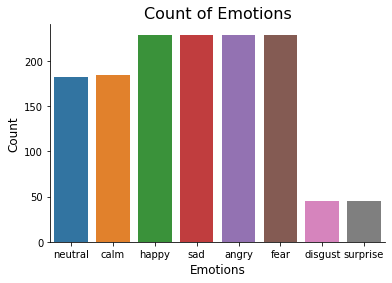

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

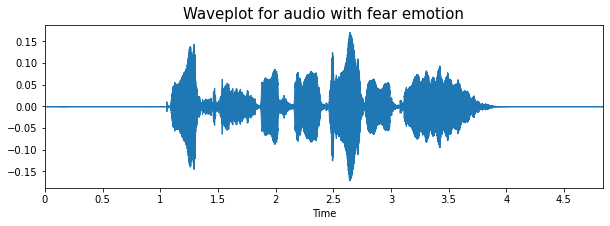

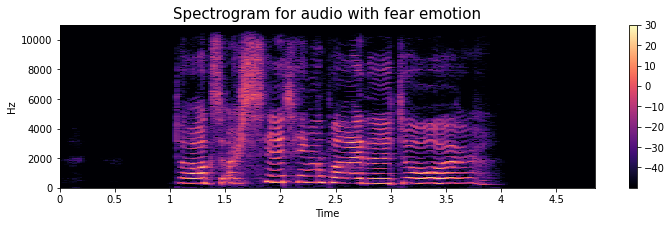

In [9]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[2]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

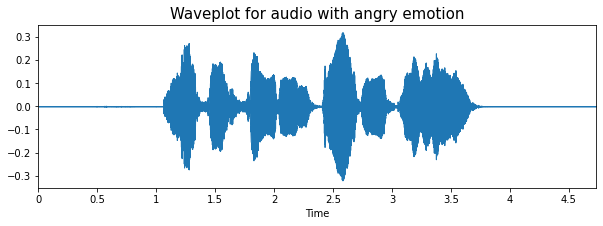

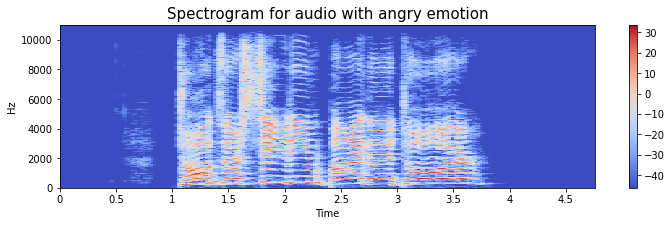

In [10]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[2]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

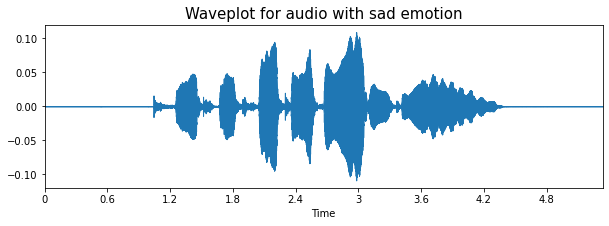

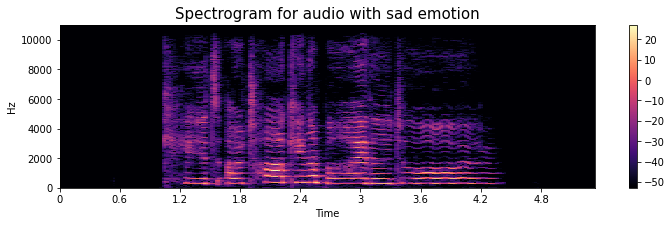

In [11]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

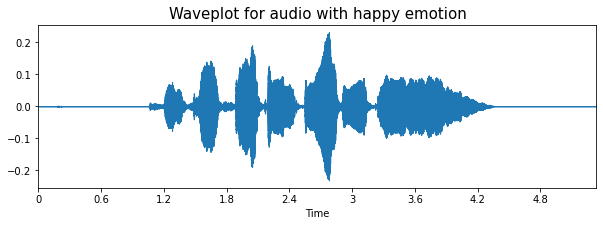

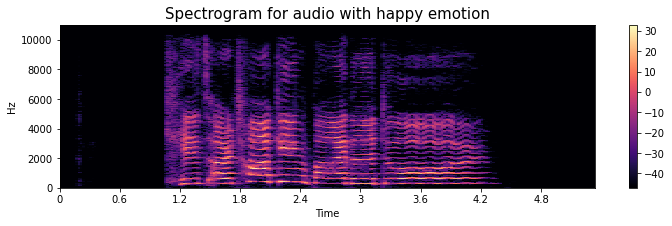

In [12]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# DATA AUGMENTATION

In [13]:
##First, let's check which augmentation techniques works better for our dataset.

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

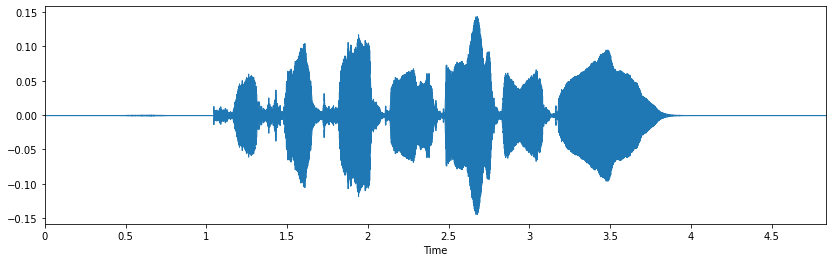

In [14]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

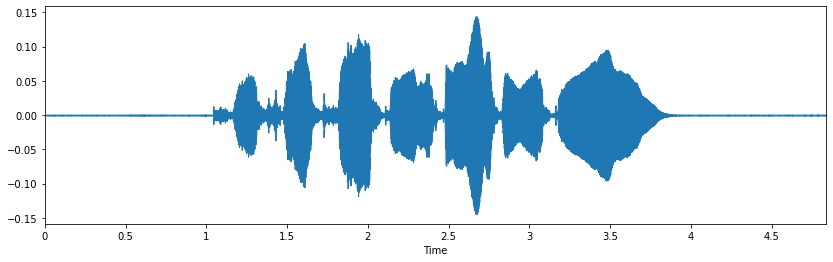

In [15]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [16]:
###Stretching

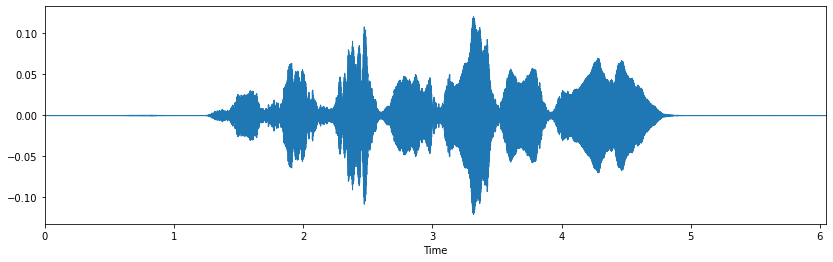

In [17]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

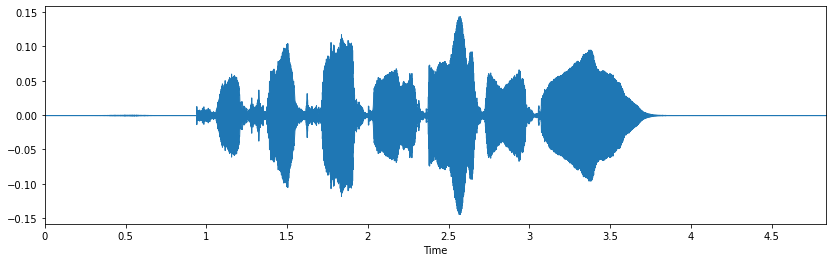

In [18]:
###Shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

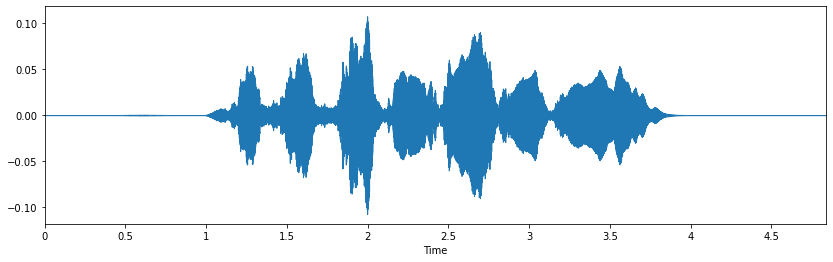

In [19]:
 ####Pitch
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)


# Feature Extraction

In [20]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [21]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [22]:
len(X), len(Y), data_path.Path.shape

(4116, 4116, (1372,))

In [23]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.200204  0.541512  0.359460  0.332878  0.326216  0.459540  0.646715   
1  0.249213  0.630199  0.503513  0.482104  0.474995  0.586844  0.721320   
2  0.162388  0.351239  0.535738  0.350808  0.293607  0.274591  0.410223   
3  0.196493  0.456571  0.355956  0.407387  0.374209  0.525797  0.675413   
4  0.204676  0.481503  0.400418  0.460209  0.439231  0.580785  0.690522   

          7         8         9  ...       153       154       155       156  \
0  0.495196  0.584393  0.474093  ...  0.000173  0.000308  0.000249  0.000106   
1  0.552780  0.611432  0.528902  ...  0.002310  0.002418  0.002324  0.002177   
2  0.616703  0.504436  0.575237  ...  0.000053  0.000035  0.000054  0.000078   
3  0.511493  0.605723  0.479096  ...  0.000066  0.000067  0.000061  0.000042   
4  0.512384  0.593108  0.488569  ...  0.000166  0.000175  0.000164  0.000142   

        157       158       159           160           161   labels  
0  0.000097  0.000049  0.000023  3.495089e-06  3.582885e-08  neutral  
1  0.002044  0.001975  0.002071  2.017364e-03  1.967924e-03  neutral  
2  0.000031  0.000014  0.000004  1.808980e-07  2.311041e-09  neutral  
3  0.000022  0.000014  0.000004  5.714334e-07  1.411661e-08  neutral  
4  0.000122  0.000114  0.000099  9.783303e-05  1.018968e-04  neutral  

[5 rows x 163 columns]

#DATA PREPARATION


In [24]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [25]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [26]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3087, 162), (3087, 8), (1029, 162), (1029, 8))

In [27]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3087, 162), (3087, 8), (1029, 162), (1029, 8))

In [28]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3087, 162, 1), (3087, 8), (1029, 162, 1), (1029, 8))

# MODEL PREPARATION

In [29]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [30]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
49/49 [==============================] - 18s 350ms/step - loss: 1.8835 - accuracy: 0.2533 - val_loss: 1.7773 - val_accuracy: 0.3158 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - 17s 341ms/step - loss: 1.7682 - accuracy: 0.2847 - val_loss: 1.6667 - val_accuracy: 0.3265 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - 17s 348ms/step - loss: 1.6764 - accuracy: 0.3201 - val_loss: 1.5826 - val_accuracy: 0.3664 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - 17s 350ms/step - loss: 1.6052 - accuracy: 0.3489 - val_loss: 1.4612 - val_accuracy: 0.4344 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - 18s 359ms/step - loss: 1.4768 - accuracy: 0.4218 - val_loss: 1.3443 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 6/50
49/49 [==============================] - 17s 354ms/step - loss: 1.3339 - accuracy: 0.4710 - val_loss: 1.1965 - val_accuracy: 0.5394 - lr: 0.0010
Epoch 7/50
49/49 [==============================] - 17s 352ms/st

# MODEL EVALUATION

33/33 [==============================] - 1s 39ms/step - loss: 0.6613 - accuracy: 0.8173
Accuracy of our model on test data :  81.72983527183533 %


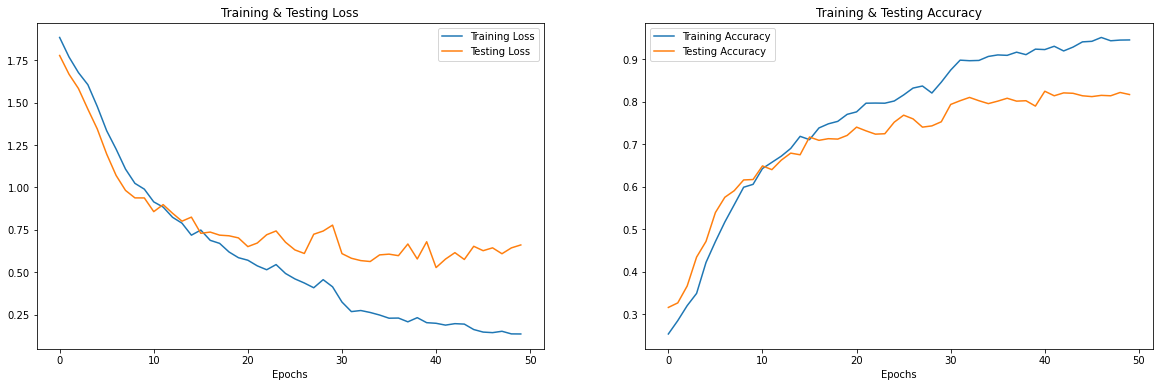

In [31]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [32]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

33/33 [==============================] - 1s 37ms/step


In [33]:
model.save('saved_model/my_model')

In [34]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          neutral       disgust
1              sad          fear
2            happy         happy
3          neutral       disgust
4             fear         angry
5              sad          fear
6          neutral       neutral
7             calm          calm
8            happy         happy
9             calm          calm

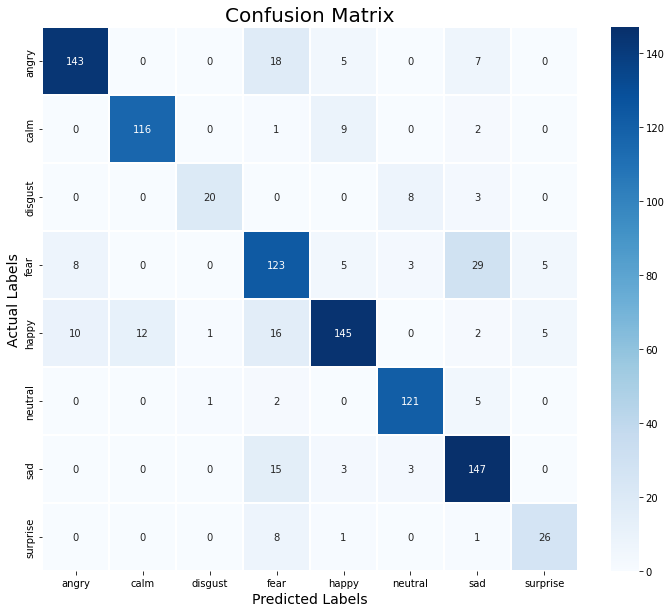

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.89      0.83      0.86       173
        calm       0.91      0.91      0.91       128
     disgust       0.91      0.65      0.75        31
        fear       0.67      0.71      0.69       173
       happy       0.86      0.76      0.81       191
     neutral       0.90      0.94      0.92       129
         sad       0.75      0.88      0.81       168
    surprise       0.72      0.72      0.72        36

    accuracy                           0.82      1029
   macro avg       0.83      0.80      0.81      1029
weighted avg       0.82      0.82      0.82      1029



# PREDICTION ON GIVEN INPUT FILE

In [37]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    return result

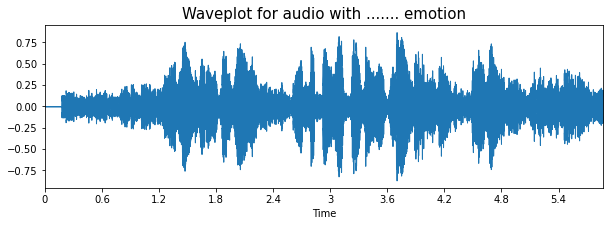

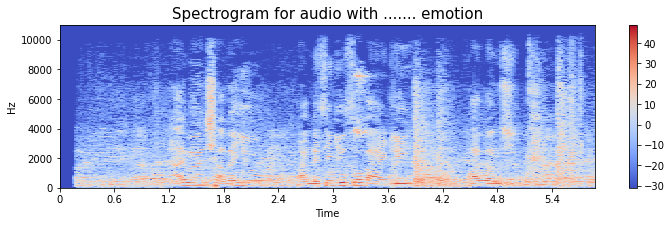

In [38]:
input="/content/drive/MyDrive/Minor project /Datesets/AUD-20221102-WA0000.wav"
emotion="......."
def find(path):
   # path = np.array(data_path.Path[data_path.Emotions==emotion])[2]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    feature1 = get_features(path)
    return feature1
Audio(input)
x_q=find(input)

In [39]:
def predict_output(x_q):
    x_q= x_q.reshape(1,x_train.shape[1],1)
    pred_test1 = model.predict(x_q)
    y_pred1 = encoder.inverse_transform(pred_test1)
    print(y_pred1)

predict_output(x_q)


1/1 [==============================] - 0s 19ms/step
[['sad']]
